In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np

import sympy
sympy.init_printing()
import unyt

In [2]:
import sys
sys.path.append('../cholla-vis')
sys.path.append('/ix/eschneider/mabruzzo/packages/gascloudutil/gascloudutil')

%load_ext autoreload
%autoreload 1
%aimport ICs
%aimport cholla_cooling

In [6]:
tmp = ICs.get_defaults()
halo = tmp['halo']
stellar_disk = tmp['stellar_disk']
razorthin_gas_disk =  tmp['razorthin_gas_disk']
starparticle_disk = tmp['starparticle_disk']

halo_gas_generator = ICs.HaloGasGenerator(
    gamma = 5.0/3.0,
    rcool = 100.0, # kpc
    T_0h = 1e6, # Kelvin
    rho_0h = 3e3, # gas eos normalized at 3e3 Msun/kpc^3 (about n_h = 10^-3.5)
    phi_fn = lambda r: (halo.potential(0.0, z_kpc = r) + 
                        stellar_disk.potential(0.0, z_kpc = r))
)

print(halo_gas_generator.calc_rho(100.0, True))
#print(halo_gas_generator.calc_rho(100.0, False))

-4.991416455024737e-08
3000.0


In [8]:
def calc_props(halo_gas_generator, r_vals, cgols_style, eos = None):
    rho_vals = halo_gas_generator.calc_rho(r_vals, cgols_style = cgols_style)
    p_vals = halo_gas_generator.calc_p_from_rho(rho_vals)
    p = unyt.unyt_array(p_vals, 'Msun/(kpc * kyr**2)')
    rho = unyt.unyt_array(rho_vals, 'Msun/kpc**3')
    ndens = (rho/(0.6 * unyt.mh_cgs))
    T = (p/unyt.kboltz_cgs/ndens).to('K')

    out = {'rho': rho, 'p' : p, 'T' : T, 'ndens' : ndens}

    if eos is not None:
        eint = (p / rho)/(eos.get_gamma()-1)
        out['tcool'] = np.abs(eos.calculate_tcool(rho,eint).to('Myr'))
    return out

phi_fn = halo_gas_generator.phi_fn
r_vals = np.linspace(1.0, 100.0, num = 1001)


{'rho': unyt_array([85943.36344002, 84551.06358757, 83187.85394255, ...,
              3012.39062004,  3006.18883759,  3000.        ], 'Msun/kpc**3'),
 'p': unyt_array([6.94706816e-03, 6.76050972e-03, 6.57982259e-03, ...,
             2.60795320e-05, 2.59901077e-05, 2.59009926e-05], 'Msun/(kpc*kyr**2)'),
 'T': unyt_array([5621305.08496149, 5560429.11999084, 5500500.46995405, ...,
              602055.39177342,  601228.78385445,  600403.33445207], 'K'),
 'ndens': unyt_array([1.70169435e+62, 1.67412656e+62, 1.64713476e+62, ...,
             5.96458866e+60, 5.95230902e+60, 5.94005501e+60], 'kpc**(-3)'),
 'tcool': unyt_array([329.25084694, 329.27254896, 329.27058217, ...,  79.95904901,
              79.86292451,  79.76708833], 'Myr')}

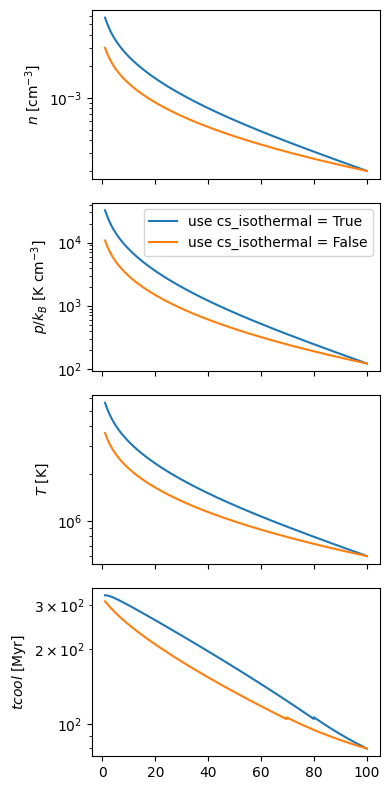

In [10]:
phi_fn = halo_gas_generator.phi_fn
r_vals = np.linspace(1.0, 100.0, num = 1001)
fig,ax_arr = plt.subplots(4,1, figsize = (4,8), sharex = True)
for cgols_style in [True,False]:
    tmp = calc_props(halo_gas_generator, r_vals, cgols_style = cgols_style, eos = cholla_cooling.ChollaEOS())
    label = f'use cs_isothermal = {cgols_style}'
    #ax_arr[0].plot(r_vals, rho.to('g/cm**3'), label = label)
    ax_arr[0].plot(r_vals, tmp['ndens'].to('cm**-3'),
                   label = label)
    ax_arr[1].plot(r_vals, (tmp['p']/unyt.kboltz_cgs).to('K/cm**3'),
                   label = label)
    ax_arr[2].plot(r_vals, tmp['T'],
                   label = label)
    ax_arr[3].plot(r_vals, tmp['tcool'],
                   label = label)
ax_arr[1].legend()
for ax in ax_arr:
    ax.set_yscale('log')
ax_arr[0].set_ylabel(r'$n$ [${\rm cm}^{-3}$]')
ax_arr[1].set_ylabel(r'$p/k_B$ [${\rm K}\ {\rm cm}^{-3}$]')
ax_arr[2].set_ylabel(r'$T$ [${\rm K}$]')
ax_arr[3].set_ylabel(r'$tcool$ [${\rm Myr}$]')
fig.tight_layout()

In [6]:
halo_gas_generator.calc_rho?

Signature: halo_gas_generator.calc_rho(r_kpc, cgols_style=True)
Docstring: <no docstring>
File:      /ix/eschneider/mabruzzo/packages/cholla-vis/cholla-vis/ICs.py
Type:      method

In [82]:
def series_1st_order(x):
    return 1 - 0.5 * x

def series_2nd_order(x):
    return 1 + x * (-0.5 + x*(1/3))

def series_3rd_order(x):
    return 1 + x*(-0.5 + 
                  x*(1/3 - 
                     x*0.25))

def series_4th_order(x):
    return 1 + x*(-0.5 + 
                  x*(1/3 - 
                     x*(0.25 +
                        x*0.2)))

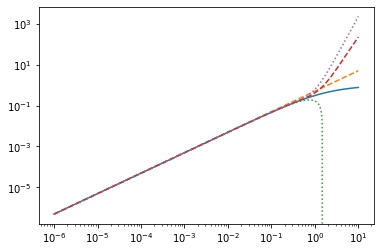

In [83]:
x_vals = np.geomspace(1e-6, 10, num = 800)
fig,ax = plt.subplots(1,1)

ax.plot(x_vals, 1 - np.log((1+x_vals)**(1/x_vals)))
ax.plot(x_vals, 1 - series_1st_order(x_vals), ls = '--')
ax.plot(x_vals, 1 - series_2nd_order(x_vals), ls = ':')
ax.plot(x_vals, 1 - series_3rd_order(x_vals), ls = '--')
ax.plot(x_vals, 1 - series_4th_order(x_vals), ls = ':')
ax.set_yscale('log')
ax.set_xscale('log')

In [68]:
series_2nd_order(x_vals) - series_4th_order(x_vals)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

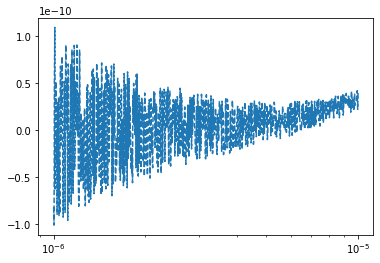

In [89]:
x_vals = np.geomspace(1e-6, 1e-5, num = 800)
y_vals = np.log((1+x_vals)**(1/x_vals))
fig,ax = plt.subplots(1,1)
#ylim = ax.get_ylim()
ax.plot(x_vals, y_vals - series_1st_order(x_vals), ls = '--')
#ax.plot(x_vals, y_vals - series_2nd_order(x_vals), ls = '--')
#ax.plot(x_vals, y_vals - series_4th_order(x_vals), ls = ':')
#ax.set_yscale('log')
ax.set_xscale('log')

In [91]:
def sympy_eval(x_vals):
    x = sympy.Symbol('x')
    expr = sympy.log(1+x)/x
    
    return np.array([
        float(expr.evalf(subs = {x : cur_x})) for cur_x in x_vals
    ])
sympy_eval(x_vals)

array([0.9999995 , 0.9999995 , 0.9999995 , 0.9999995 , 0.99999949,
       0.99999949, 0.99999949, 0.99999949, 0.99999949, 0.99999949,
       0.99999949, 0.99999948, 0.99999948, 0.99999948, 0.99999948,
       0.99999948, 0.99999948, 0.99999947, 0.99999947, 0.99999947,
       0.99999947, 0.99999947, 0.99999947, 0.99999947, 0.99999946,
       0.99999946, 0.99999946, 0.99999946, 0.99999946, 0.99999946,
       0.99999945, 0.99999945, 0.99999945, 0.99999945, 0.99999945,
       0.99999945, 0.99999945, 0.99999944, 0.99999944, 0.99999944,
       0.99999944, 0.99999944, 0.99999944, 0.99999943, 0.99999943,
       0.99999943, 0.99999943, 0.99999943, 0.99999943, 0.99999942,
       0.99999942, 0.99999942, 0.99999942, 0.99999942, 0.99999942,
       0.99999941, 0.99999941, 0.99999941, 0.99999941, 0.99999941,
       0.99999941, 0.9999994 , 0.9999994 , 0.9999994 , 0.9999994 ,
       0.9999994 , 0.9999994 , 0.99999939, 0.99999939, 0.99999939,
       0.99999939, 0.99999939, 0.99999938, 0.99999938, 0.99999

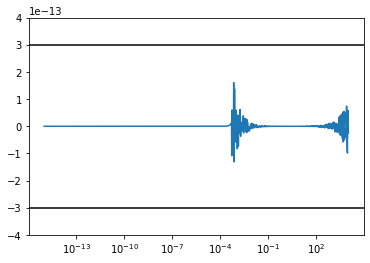

In [159]:



x_vals = np.geomspace(1e-15, 1e4, num=1101)
fig,ax = plt.subplots(1,1)

ref = sympy_eval(x_vals)

def naive(x_vals):
    return np.log((1+x_vals)**(1/x_vals))






ax.set_xscale('log')


ax.plot(x_vals, (ref - invx_times_ln_1px(x_vals)) / ref, ls = '-')
#ax.plot(x_vals, (ref - series_3rd_order(x_vals)) / ref, ls = '-')
#ax.plot(x_vals, (ref - series_4th_order(x_vals)) / ref, ls = '--')

ax.axhline(3e-13, color = 'k')
ax.axhline(-3e-13, color = 'k')

ax.set_ylim(-4e-13,4e-13)
#ax.set_ylim(-1e-11,1e-11)